In [1]:
import spatialdata as sd
import anndata as ad
import pandas as pd
import dask.dataframe as dd
import numpy as np

import abc_load as abc
import ccf_registration as ccf

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/spatialdata/__init__.py:11: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [50]:
from importlib import reload
reload(abc)
reload(ccf)

<module 'ccf_registration' from '/root/capsule/code/ccf_registration.py'>

In [3]:
import matplotlib.pyplot as plt
import spatialdata_plot
%matplotlib inline

## defs

In [ ]:
def get_target_grid_center(source, target, inv_transform):
    target_z = target['z'].max().compute()
    # calculate xy center by pullback from image center
    source_center = np.array([len(source[i])/2 for i in 'xyz'])
    mat = inv_transform.inverse().to_affine_matrix('xyz','xyz')
    target_center = ccf.apply_affine_left(mat, source_center)[:,0]
    target_center[2] = target_z
    return target_center

In [ ]:
from scipy.ndimage import map_coordinates
def map_image_to_slice(source, target, scale=None):
    # expand to diagonal dimension to allow arbitrary rotation
    ngrid = int(np.linalg.norm(np.array(source.shape)))

    # xyz grid (pixel centers)
    grid = np.stack((*np.mgrid[0:ngrid, 0:ngrid][::-1], np.zeros((ngrid, ngrid))), axis=0) + 0.5
    grid_points = sd.models.PointsModel.parse(grid.reshape(3, -1).T)

    inv_transform = sd.transformations.get_transformation_between_coordinate_systems(sdata, target, source)
    target_center = get_target_grid_center(source, target, inv_transform)

    if scale is None:
        scale = np.linalg.det(inv_transform.inverse().to_affine_matrix('xyz', 'xyz'))**(1/3)
        
    target_grid_transform = sd.transformations.Sequence([
        sd.transformations.Translation(np.array([-ngrid/2, -ngrid/2, 0]) - 0.5, 'xyz'),
        sd.transformations.Scale(scale*np.array([1, 1, 1]), 'xyz'),
        sd.transformations.Translation(target_center, 'xyz')
    ])

    source_points = sd.transform(
        grid_points,
        sd.transformations.Sequence([target_grid_transform, inv_transform]),
        )


    # scipy.ndimage evaluates at integers not pixel centers
    points = source_points[['z','y','x']].values.T - 0.5
    target_img = map_coordinates(imdata, points, prefilter=False, order=0).reshape(ngrid, ngrid)
    # target_img = np.flipud(target_img)
    return target_img, target_grid_transform

## load

In [4]:
df_full = abc.get_combined_metadata(as_dask=True).compute()
df_full = df_full.set_index('cell_label')


In [47]:

# flip may not matter if using normalized coords?
df_full[['y_section', 'y_reconstructed']] *= -1

In [51]:
# df = abc.label_thalamus_spatial_subset(df_full, filter=True)
coords = ['x_section', 'y_section', 'z_section']
ref_subset = abc.get_thalamus_reference_ids()
df = ccf.subset_to_ref_bounds(df_full, coords, ref_subset)

slice_label = 'slice_int'
df[slice_label] = df['z_section'].apply(lambda x: int(x*10))

df = df.assign(**df.select_dtypes(include=["category"]).apply(lambda x: x.cat.remove_unused_categories()).to_dict(orient='series'))

In [91]:

# df_ref = df_full.loc[ref_subset.intersection(df_full.index)]
xy = df[coords[:2]]
df_min = xy.min()
df_max = xy.max()
norm_transform = sd.transformations.Sequence([
    sd.transformations.Translation(np.array([-1*df_min[0], -1*df_max[1]]), 'xy'),
    sd.transformations.Scale(1/(df_max-df_min) * np.array([1, -1]), 'xy')
    # above is compensating for inverted y in quicknii template, should be:
    # sd.transformations.Translation(-1*df_min, 'xy'),
    # sd.transformations.Scale(1/(df_max-df_min), 'xy')
    ])



In [92]:
# create separate coordinate systems for each section
transform_dict = ccf.read_quicknii_file("../resources/adjusted_10-10_final.json", scale=25)
cells_by_section = dict()
for name, df_section in df.groupby(slice_label, observed=True):
    ccf_transform = sd.transformations.Affine(transform_dict[name].T, 'xyz', 'zyx')
    # cells_by_section[name] = sd.models.ShapesModel.parse(
    #     df_section[coords].values, geometry=0, radius=10e-6, 
    cells_by_section[str(name)] = sd.models.PointsModel.parse(
        # df_section[coords].values, 
        # annotation=df_section.drop(columns=coords),
#! converting to dask here is essential to preserve dtypes
        dd.from_pandas(df_section, npartitions=1), coordinates=dict(zip('xyz', coords)),
        transformations={'ccf': sd.transformations.Sequence([norm_transform, ccf_transform]),
                         str(name): sd.transformations.Identity()})

In [93]:
#! what is going on here!>? (categoricals lost, maybe others)
# test = sd.models.PointsModel.parse(df.head(), coordinates=dict(zip('xyz', coords)))
# test.head()


In [94]:

img_transform = sd.transformations.Scale(10e-3*np.ones(3), 'xyz')
# transformation entry takes form of [primary coordinate system name]: [transform from intrinsic coords/pixels to that system]

# TODO: the LabelsModel should take care of the dtype! also should be typed on load...
imdata = abc.get_ccf_labels_image()
labels = sd.models.Labels3DModel.parse(imdata, dims='zyx', transformations={'ccf': img_transform})
# del imdata, img

In [107]:
# load ccf region metadata
# (not included/updated in 20230830 version)
ccf_df = (
        pd.read_csv(
        abc.ABC_ROOT/f"metadata/Allen-CCF-2020/20230630/parcellation_to_parcellation_term_membership.csv",
        dtype={'parcellation_term_acronym': 'category'})
          .query("parcellation_term_set_name=='substructure'")
)

instance_key='parcellation_index'
region_key='annotated_element'
# regions = list(sdata.labels.keys())
regions = [f"{section}_ccf" for section in cells_by_section.keys()]
# need to repeat table for every annotated element
obs = pd.concat([ccf_df.assign(**{region_key: x}) for x in regions])
ccf_annotation = sd.models.TableModel.parse(ad.AnnData(obs=obs), region=regions, region_key=region_key, instance_key=instance_key)
#! won't save?
# sdata.table = ccf_annotation

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_30278/3926364868.py:16: UserWarning: Converting `region_key: annotated_element` to categorical dtype.
  ccf_annotation = sd.models.TableModel.parse(ad.AnnData(obs=obs), region=regions, region_key=region_key, instance_key=instance_key)


In [108]:

sdata = sd.SpatialData.from_elements_dict(dict(ccf_regions=labels, table=ccf_annotation, **cells_by_section))

labels_dict = dict(ccf_regions=labels)
for section in sdata.points.keys():
    target = sdata[section]
    source = sdata['ccf_regions']
    scale = 10e-3
    target_img, target_grid_transform = map_image_to_slice(source, target, scale=scale)
    section_labels = sd.models.Labels2DModel.parse(target_img, dims='yx', 
                             transformations={section: target_grid_transform})
    sdata.add_labels(f"{section}_ccf", section_labels)
    # labels_dict["{section}_ccf"] = section_labels

In [110]:
# overwrite=True is broken?
sdata.write("/scratch/abc_atlas_realigned.zarr")

no parent found for <ome_zarr.reader.Label object at 0x7f1318f24850>: None
no parent found for <ome_zarr.reader.Label object at 0x7f13284e5070>: None
no parent found for <ome_zarr.reader.Label object at 0x7f12efde3df0>: None
no parent found for <ome_zarr.reader.Label object at 0x7f13284e5070>: None
no parent found for <ome_zarr.reader.Label object at 0x7f1369810160>: None
no parent found for <ome_zarr.reader.Label object at 0x7f1368a0d610>: None
no parent found for <ome_zarr.reader.Label object at 0x7f12f28a0ee0>: None
no parent found for <ome_zarr.reader.Label object at 0x7f131d21e490>: None
no parent found for <ome_zarr.reader.Label object at 0x7f13688350a0>: None
no parent found for <ome_zarr.reader.Label object at 0x7f1368a06f10>: None
no parent found for <ome_zarr.reader.Label object at 0x7f131d21e490>: None
no parent found for <ome_zarr.reader.Label object at 0x7f13d7407160>: None
no parent found for <ome_zarr.reader.Label object at 0x7f12f3c30760>: None
no parent found for <ome_

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.9/site-packages/spatialdata_plot/pl/render.py:263: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  _cax = ax.scatter(
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.9/site-packages/spatiald

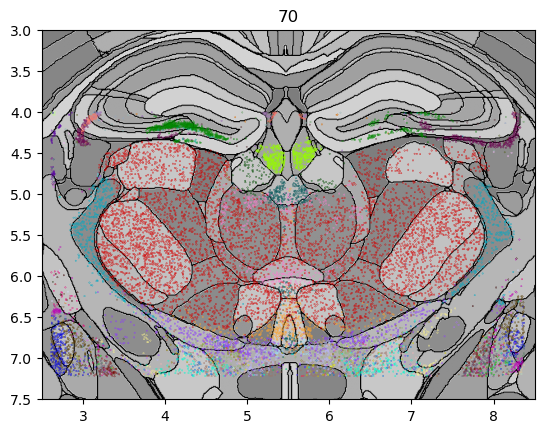

In [111]:
from colorcet import glasbey, gray
section = '70'
fig, ax = plt.subplots()


ccf_label = 'parcellation_term_acronym'
i_set = np.unique(sdata[f"{section}_ccf"])
ccf_groups = ccf_df.loc[ccf_df[instance_key].isin(i_set), ccf_label].unique()

groups = sdata[section]['subclass'].value_counts().loc[lambda x: x>0].index.compute()
groups = [x for x in groups if not 'NN' in x]
(
    sdata
    .pl.render_points(size=0.02, color='subclass', groups=groups, palette=glasbey)
    .pl.render_labels(palette=gray*4, color=ccf_label, groups=ccf_groups, outline=True)
    .pl.show(coordinate_systems=[section], ax=ax, na_in_legend=False)
)
ax.set_ylim(7.5, 3)
ax.set_xlim(2.5, 8.5)
ax.get_legend().remove()
plt.show()

## testing

In [ ]:
# test single section

section = '70'
target = sdata[section]
source = sdata['ccf_regions']
scale = 10e-3
target_img, target_grid_transform = map_image_to_slice(source, target, scale=scale)
section_labels = sd.models.Labels2DModel.parse(
    target_img, dims='yx', 
    transformations={section: target_grid_transform})
sdata.add_labels(f"{section}_ccf", section_labels)

#! trimmed dimensions are erased when sdata creates SpatialImage
# section_labels = section_labels[(section_labels != 0).any(dim='x'),
#                (section_labels != 0).any(dim='y')]

In [12]:
import xarray as xr
coords = np.arange(-ngrid/2, ngrid/2)
# use xarray broadcasting to create a centered coord grid
# (dims are named 'xx' etc as matching variable names not allowed)
# (yx order for image layout)
axes = [xr.DataArray(data=scale*coords + target_center[n], coords={i+i: coords}, dims=i+i, name=i) 
        for n, i in enumerate('xy')]
grid = xr.merge(axes[::-1])
grid['z'] = target_z

In [13]:
target_points = grid.to_array().to_numpy().reshape(3, -1)
source_points = ccf.apply_affine_left(mat, target_points)

target_img = scipy.ndimage.map_coordinates(imdata, source_points[::-1, :] - 0.5, prefilter=False, order=0)

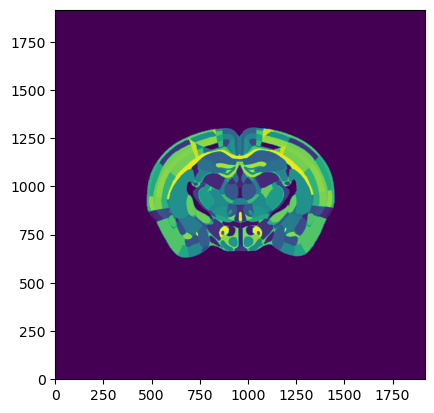

In [77]:
img = target_img
plt.imshow(img, origin='lower')
plt.show()

In [ ]:

# option using sdata PointsModel
# if added to sdata could specify coord system and infer transform, keeping original coords too
# (maybe nicer for creating SpatialImage coords)
source_points = sd.transform(sd.models.PointsModel.parse(target_points.T), transform)

In [ ]:
# no way to selectively index to fill past edges?! 
# (ie where() with dask delayed evaluation?)
# round_to_centers = lambda x: (x - 0.5).round().astype(int)
# ind = round_to_centers(source_points).compute()
# ind[ind<0] = np.nan
# for i in 'xyz':
#     ind[i] = ind[i].where(ind[i] < len(source[i]))
    
# can't index with nan
# x, y, z = (xr.DataArray(ind[i], dims=['i']) for i in 'xyz')
# target_img = source[z, y, x]

In [30]:
# rounding, reindexing, and array indexing mimics map_coordinates (slowly)
# rounding is necessary so reindexing (on unique) is smaller
round_to_centers = lambda x: (x - 0.5).round() + 0.5
ind = round_to_centers(source_points)
# dask option needed to not complain here (set T or F)
import dask.config
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
# reindex will fill nan for outside points
# (could also do by inequality and index without rounding)
    subset = source.reindex({x: ind[x].unique() for x in ind.columns}).compute()
# defining single shared dim prevents broadcasting
# whereas this broadcasts to a cube array
# subset.sel(z=ind['z'], y=ind['y'], x=ind['x'])
x, y, z = (xr.DataArray(ind[i], dims=['i']) for i in 'xyz')
target_img = subset.loc[z, y, x]

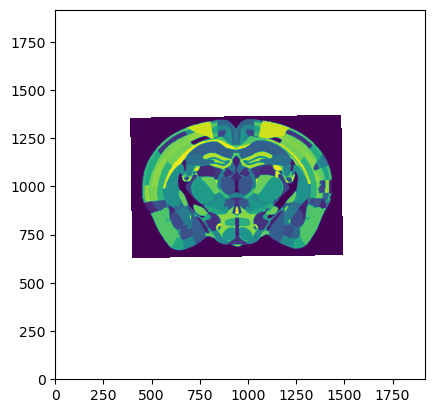

In [18]:
img = target_img.values.reshape(ngrid, ngrid).T
plt.imshow(img, origin='lower')
plt.show()

In [173]:
from dask.array import from_array
from spatial_image import SpatialImage

img_arr = xr.DataArray(from_array(img), 
                       coords={i: grid.data_vars[i].values for i in 'xyz'}, dims=['y','x'])


img_spa = SpatialImage(img_arr, attrs=dict(transform={section: sd.transformations.Identity()}))
img_spa

<xarray.SpatialImage 'array-774ab99207662a2e56b840184a683845' (y: 1918, x: 1918)>
dask.array<array, shape=(1918, 1918), dtype=float64, chunksize=(1918, 1918), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -4.211 -4.201 -4.191 -4.181 ... 14.93 14.94 14.95 14.96
  * y        (y) float64 -3.914 -3.904 -3.894 -3.884 ... 15.23 15.24 15.25 15.26
    z        float64 7.0
Attributes:
    transform:  {'70': Identity }

In [181]:
coords_dict = {i: xr.DataArray(target[i], dims=['i']) for i in 'xy'}
cell_regions = img_spa.sel(**coords_dict, method='nearest', tolerance=0.5).values.astype(int)

In [216]:
# coords = ['x_ccf','y_ccf','z_ccf']
# cells = target.dropna(subset=coords)
# coords_dict = {i[0]: xr.DataArray(cells[i].dropna()/0.01, dims=['i']) for i in coords}
cells = sd.transform(target, transform)
coords_dict = {i: xr.DataArray(cells[i], dims=['i']) for i in 'xyz'}
cell_regions2 = source.sel(**coords_dict, method='nearest', tolerance=0.5).values

In [220]:
np.mean(cell_regions2 == cell_regions)

0.9852001345442314

In [ ]:
# LabelsModel replaces existing coordinates with pixel indices!!
# sd.models.Labels2DModel.parse(data=img_arr, )

# same happens if added directly as SpatialImage
# name = f"ccf_{section}"
# sdata.add_labels(name, img_spa)
# sdata[name]

In [41]:
# fails beyond tolerance rather than fill nan
# coords_dict = {i: xr.DataArray(transformed_coords[i], dims=['i']) for i in 'xyz'}
# transformed_img = source.sel(**coords_dict, method='nearest', tolerance=0.5)